## Машинное обучение: задача классификации

Задача классификации ставится, когда необходимо разделить объекты в датасете на два или более классов. Можно сказать, что в рассмотренной нами задаче регрессии целевая переменная - числовая, а в задаче классификации - категориальная.

Обычно отдельно выделяют **бинарную** или **двоичную классификацию**, и **многоклассовую** (которая является более общим случаем бинарной). Многоклассовая классификация может быть сведена к двоичной путём построения нескольких классификаторов one-vs-all.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.datasets

Чтобы посмотреть, как решается задача классификации, сгенерируем случайный датасет. Для наглядности будем использовать размерность задачи 2, чтобы можно было визуализировать картину на плоскости:

In [ ]:
X,Y = sk.datasets.make_classification(
    n_samples=1000,n_features=2,random_state=13,
    n_informative=2,n_redundant=0,
    class_sep=2,n_clusters_per_class=1,flip_y=0)

plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
plt.show()

## Логистическая регрессия

Простейший линейный алгоритм решения задачи двоичной классификации - это **логистическая регрессия**. В ней используется линейная решающая функция $f_{W,b}(x)=Wx+b$, где $W$ - матрица весов (weights), $b$ - сдвиг (bias).

> **Замечание:** несмотря на название, логистическая регрессия решает задачу классификации!

Можно считать, что класс объекта определяется знаком решающей функции $f$. Поскольку в нашем датасете $y_i\in\{0,1\}$, предсказываемое значение $y={1\over2}(\mathrm{sign} f(x)+1)$. Говорят, что после линейного преобразования применяется **передаточная функция** $\sigma(x)={1\over2}(\mathrm{sign}(x)+1)$, а $y=\sigma(f(x))$.

In [ ]:
nx=np.linspace(-5,5)
plt.plot(nx,0.5*(np.sign(nx)+1))
plt.show()


Однако данная передаточная функция не является гладкой, а для использования метода градиентного спуска нам хотелось бы иметь дифференцируемую функцию. Поэтому обычно в качестве передаточной функции используют функцию **сигмоид** $$\sigma(x)={1\over1+e^{-x}}$$

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.linspace(-5,5)
plt.plot(x,sigmoid(x))
plt.grid()
plt.show()

Используем, как и в прошлый раз, метод градиентного спуска:

In [ ]:
W = np.random.normal(size=(2,))
b = np.random.normal(size=(1,))

def mse_loss(W,b):
  return np.average(np.square(sigmoid(np.matmul(X,W)+b)-Y))

mse_loss(W,b)

Производную в процессе градиентного спуска можно считать и численно. Так обычно не делают, поскольку для многомерного случая это слишком вычислительно сложный процесс, но для примера - попробуем так сделать. Опишем функцию численного дифференцирования:

In [ ]:
def d(f,x,dx=0.1):
    n = x.shape[0]
    r = np.zeros_like(x)
    for i in range(n):
        dxc = np.eye(n)[i]*dx
        r[i] = (f(x+dxc)-f(x))/dx
    return r

d(lambda x: mse_loss(x,b),W) # производная по dW

Цикл оптимизации выглядит также, как и в случае регрессии:

In [ ]:
W = np.random.normal(size=(2,))
b = np.random.normal(size=(1,))

eta = 0.1
n = len(X)
for i in range(100):
    print(f"({W} {b}) -> loss={mse_loss(W,b)}")
    #print(f"dldw={dldw}, dldb={dldb}, W={W}, b={b}")

    dldw = d(lambda x: mse_loss(x,b),W)
    dldb = d(lambda x: mse_loss(W,x),b)
    h = sigmoid(np.matmul(X,W)+b)
    W-=eta*dldw
    b-=eta*dldb


Посмотрим, как разделяющая прямая выглядит на графике. Уравнение разделяющей прямой имеет вид $w_0x+w_1y+b = 0$, где $x,y$ - переменные по осям абсцисс и ординат на графике, $w_0, w_1, b$ - веса модели. Отсюда получаем уравение прямой, выражая $y$ через $x$:
$$
y = {-b\over w_1}- {w_0\over w_1}x
$$

In [ ]:
plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
xs = X[:,0].min(), X[:,0].max()
plt.plot(xs,[-b/W[1]-x*W[0]/W[1] for x in xs])
plt.ylim([-2,6])
plt.show()

Видно, что мы получили неплохую разделяющую прямую, но если мы попробуем запустить процесс несколько раз то увидим, что он не всегда хорошо сходится. Это происходит потому, что функция потерь MSE для задач классификации находится в пределах 0-1, поскольку худшее, что может случиться - это мы неправильно угадаем класс. Иными словами, сигмоид как передаточная функция теряет информацию о том, насколько сильно мы ошиблись - из-за того, что он асимптотически быстро стремиться к 0 или к 1 при больших по модулю значениях линейной функции.

Для того, чтобы компенсировать это, в качестве функции ошибки для задач регрессии используют логарифмическую функцию потерь. Например, если ожидаемый класс $\hat y=1$, а на выходе нашей модели (после сигмоиды) мы получаем значение $y=0.1$, то ошибка будет равна $-\log 0.1\approx 2.3$. А при стремлении решающей функции к 0 логарифм вообще будет неограниченно возрастать! Если же мы угадали с классом и предсказали значение 1, то ошибка будет равна нулю.

> Выход решающей функции (после сигмоиды) можно рассматривать как **вероятность** того, что ожидаемый класс - 1. 


In [ ]:
nx = np.linspace(0.1,5)/5
plt.plot(nx,-np.log(nx))
plt.show()


Аналогично, для ожидаемого класса $\hat y=0$ ошибка будет равна $-\log(1-y)$, где $y$ - выход решающей функции. С учётом этого, если обозначить ожидаемый класс как $\hat y \in\{0,1\}$, то функция ошибки будет равна
$$
\mathrm{logloss}(y,\hat y) = \hat y\log y + (1-\hat y)\log(1-y)
$$

> Для более общего случая, когда мы имеем $n>2$ классов, вероятность появления $i$-го класса предсказана как $p_i$ ($\sum p_i=1$), при этом номер правильного класса - $\hat y$, логистическая функция ошибка равна $-\log p_{\hat y}$. 

$$
-\log p_{\hat y}
$$

Пробуем запустить оптимизацию с логистической функцией ошибки. В этом примере мы используем явно вычисленные производные ошибки по $W$ и $b$:

In [ ]:
W = np.random.normal(size=(2,))
b = np.random.normal(size=(1,))

def loss(W, b):
    h = sigmoid(np.matmul(X,W)+b)
    return (-Y * np.log(h) - (1 - Y) * np.log(1 - h)).mean()

eta = 0.2
n = len(X)
for i in range(100):
    print(f"({W} {b}) -> loss={loss(W,b)}")
    #print(f"dldw={dldw}, dldb={dldb}, W={W}, b={b}")

    h = sigmoid(np.matmul(X,W)+b)
    dldw = np.matmul(X.T,h-Y.T)/n
    dldb = (h-Y.T).mean()
    W-=eta*dldw
    b-=eta*dldb


In [ ]:
plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
xs = X[:,0].min(), X[:,0].max()
plt.plot(xs,[-b/W[1]-x*W[0]/W[1] for x in xs])
plt.ylim([-2,6])
plt.show()

## Классификация в SkLearn

Мы можем использовать библиотеку Scikit Learn для решения задач классификации. Разобьем на обучающую и проверочную выборки, и посмотрим на точность модели:

In [ ]:
import sklearn.linear_model
import sklearn.preprocessing

X_train,X_test,Y_train,Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)

model = sk.linear_model.LogisticRegression().fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print(f"Accuracy={sk.metrics.accuracy_score(Y_test,Y_pred)}")

Можно также предсказывать вероятности принадлежности классам:

In [ ]:
model.predict_proba(X_test[:5])

Посмотрим, как выглядит разделяющая прямая:

In [ ]:
plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
xs = X[:,0].min(), X[:,0].max()
b = model.intercept_
W = model.coef_[0]
plt.plot(xs,[-b/W[1]-x*W[0]/W[1] for x in xs])
plt.ylim([-2,6])
plt.show()

Рассмотрим практическую задачу - классификацияю пассажиров Титаника. Для начала загрузим датасет:

In [ ]:
import pandas as pd
df = pd.read_csv("../../../data/titanic.csv")
df

Для начала нам необходимо проделать преобразование категориальных признаков в числовые, как мы рассматривали в прошлой лекции. В нашем случае, необходимо преобразовать пол, который является номинальным признаком. Поскольку значения всего два, не очень принципиально, использовать ли Label Encoding или One-Hot Encoding.

In [ ]:
df["nsex"] = df['sex'].apply(lambda x: 0 if x=="male" else 1)

Также можно заметить, что некоторые значения возраста отсутствуют. Посмотрим, сколько таких строк:

In [ ]:
df['age'].isna().sum()

У нас есть несколько вариантов, как быть с этим показателем:
* Убрать все строки, где есть отсутствующие значения. Это слишком дорогой способ, поскольку у нас значения отстуствуют в более, чем 10% строк.
* Убрать весь столбец `age` из рассмотрения. Также не очень хороший вариант
* Заполнить отсутствующие значения некоторыми другими, например, средним:

In [ ]:
df['fage'] = df['age'].fillna(df['age'].mean())
df

Теперь, когда мы очистили данные, можем извлечь интересующие нас признаки и разбить на обучающую и тестовую выборку:

In [ ]:
features = ['pclass','nsex','fage','sibsp','parch']
X = df[features]
Y = df['survived']
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)

Обучаем модель:

In [ ]:
model = sk.linear_model.LogisticRegression().fit(X_train,Y_train)

Y_pred = model.predict(X_test)

print(f"Accuracy={sk.metrics.accuracy_score(Y_test,Y_pred)}")

Чтобы поподробнее разобраться в том, как устроена ошибка, посмотрим на так называемую **матрицу ошибок** (*confusion matrix*):

In [ ]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,Y_test)
plt.show()

Для классификации имеет смысл говорить также про другие метрики:

In [ ]:
print(sk.metrics.classification_report(Y_test,Y_pred))

Посмотрим, как выглядит ROC-кривая для нашей модели и метрика AUC: 

In [ ]:
fpr, tpr, thresholds = sk.metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(7,7))
plt.plot(fpr,tpr)
plt.grid()
plt.plot([0,1],[0,1],c='r')

In [ ]:
sk.metrics.auc(fpr,tpr)

Попробуем интерпретировать линейную модель, посмотрев на коэффициенты:

In [ ]:
list(zip(['pclass','nsex','fage','sibsp','parch'],model.coef_[0]))

In [ ]:
plt.bar(['pclass','nsex','fage','sibsp','parch'],model.coef_[0])

## Деревья решений

В отличие от линейных моделей, деревья решений хорошо работают для категориальных атрибутов. Простейший алгоритм построения дерева называется [ID3](https://ru.wikipedia.org/wiki/ID3_(%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC)).

Будем рассматривать только категориальные атрибуты нашей модели - пол (`sex`) и класс (`pclass`). Добавим для интереса ещё один категориальный атрибут: возраст:


In [ ]:
df['agecat'] = df['age'].apply(lambda x: "young" if x<18 else "old" if x>45 else "middle")

Предположим, мы хотим предсказывать вероятность выживания только на основе пола. В этом случае, средняя вероятность равна:

In [ ]:
for s in df['sex'].unique():
    print(f"Probability for sex={s} is {df[df['sex']==s]['survived'].mean()}")

Т.е. мы можем предсказывать "выжил" для всех женщин, и "не выжил" для все мужчин - и это будет давать нам некоторую точность предсказания.

Но вдруг было бы правильнее сначала смотреть не на пол, а на класс? Посмотрим, какая точность была бы у результирующей модели, если бы мы выбрали в качестве решающего атрибута пол, класс или возрастную категорию:

In [ ]:
def accuracy_by_attr(df,attr):
    p = {}
    for k in df[attr].unique():
        p[k] = int(df[df[attr]==k]['survived'].mean()>=0.5)
    return df.apply(lambda x: p[x[attr]]==x['survived'],axis=1).mean()

for a in ['pclass','sex','agecat']:
    print(f"Accuracy by {a} = {accuracy_by_attr(df,a)}")

Таким образом, выгоднее всего сначала смотреть на пол пассажира. Далее, разделяем датасет на два подмножества, и для каждого из них повторяем этот процесс. Например, вот как будет выглядеть точность для мужчин и женщин, если смотреть далее на атрибут `pclass`:

In [ ]:
for sex in ['male','female']:
    df_1 = df[df['sex']==sex]
    print(f"{sex}, accuracy by pclass = {accuracy_by_attr(df_1,'pclass')}")

Усовершенствованным вариантов ID3 является алгоритм [С4.5](https://ru.wikipedia.org/wiki/C4.5), разработанный тем же автором, Джоном Квинланом. В нём поддерживается отсечение ветвей, работа с числовыми атрибутами (т.е. автоматическое добавление оптимального разделения наподобие того, как мы вручную делали с возрастом), а также работа с неполной выборкой (с отсутствующими атрибутами).

Применим классификацию в виде деревья решений из SkLearn:

In [ ]:
import sklearn.tree 

model = sk.tree.DecisionTreeClassifier().fit(X_train,Y_train)
Y_pred = model.predict(X_test)
sk.metrics.accuracy_score(Y_test,Y_pred)

Как видим, точность примерно соответствует линейной модели. В зависимости от задачи, однако, мы можем получать разную точность - именно поэтому имеет право на жизнь подход Automatic ML, о котором мы говорили ранее.

Плюсом деревьев решений является их интерпретируемость. Можем попробовать построить дерево небольшой глубины, и затем его визуализировать:

In [ ]:
model = sk.tree.DecisionTreeClassifier(max_depth=3).fit(X_train,Y_train)

import graphviz
graphviz.backend.dot_command.DOT_BINARY = 'c:/winapp/conda/Library/bin/graphviz/dot.exe'

graphviz.Source(
    sk.tree.export_graphviz(model,feature_names=features,class_names=['no','yes'],
    filled=True, rounded=True, special_characters=True,impurity=False)
)

Видим, что как и в нашем случае пол является главным решающим фактором, после чего наступают более сложные решения. 

### Машина опорных векторов (SVM)

В заключение поговорим о ещё одной линейной модели - машине опорных векторов. Для этого вернёмся к исходной задаче - разделении классов точек на плоскости.

In [ ]:
X,Y = sk.datasets.make_classification(
    n_samples=1000,n_features=2,random_state=3,
    n_informative=2,n_redundant=0,
    class_sep=2,n_clusters_per_class=1,flip_y=0)

plt.scatter(X[:,0],X[:,1],c=['r' if x else 'b' for x in Y])
plt.show()

Идея метода опорных векторов состоит в том, чтобы построить такую разделяющую прямую $w_0x_0+w_1x_1+b=0$, которая бы обеспечивала максимальный "зазор" между разделяемыми классами. Варьируя угол наклона разделяющей прямой мы добиваемся максимального зазора. При этом элементы, на которые "опираются" прямые, называются **опорными векторами**:

In [ ]:
import sklearn.svm, sklearn.inspection

model = sk.svm.SVC(kernel="linear", C=1000)
model.fit(X, Y)

plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])

ax = plt.gca()
# строим разделяющие прямые
sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)
# обводим опорные вектора
ax.scatter(
    model.support_vectors_[:, 0], model.support_vectors_[:, 1],
    s=100, linewidth=1, facecolors="none", edgecolors="k")

plt.show()

Данный метод похож на логистическую регрессию, но использует другую функцию ошибки, позволяющую уменьшить зазор. За счет того, что при построении разделяющей прямой (или гиперплоскости, в случае большей размерности) используются близлежащие точки - опорные вектора, повышается эффективность метода для большого количества входных обучающих данных.

Для разделения линейно - неразделимых множеств SVM допускает использование нелинейных **функций ядра** (*kernel functions*). Например, если мы будет использовать метод SVM из Scikit Learn по умолчанию, то будут использованы нелинейные функции ядра: 

In [ ]:
import sklearn.svm, sklearn.inspection

model = sk.svm.SVC()
model.fit(X, Y)

plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])

ax = plt.gca()
# строим разделяющие прямые
sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)
# обводим опорные вектора
ax.scatter(
    model.support_vectors_[:, 0], model.support_vectors_[:, 1],
    s=100, linewidth=1, facecolors="none", edgecolors="k")

plt.show()

Рассмотрим случай, когда множества точек не являются линейно разделимыми. Такой датасет мы можем сгненерировать при помощи функции `make_circles`:

In [ ]:
X,Y = sk.datasets.make_circles(n_samples=100,factor=0.5,noise=0.1)
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])
plt.show()

Применим к этому алгоритм опорных вектором с нелинейными ядерными функциями:

In [ ]:
model = sk.svm.SVC()
model.fit(X, Y)

plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=['r' if x else 'b' for x in Y])
ax = plt.gca()
# строим разделяющие прямые
sk.inspection.DecisionBoundaryDisplay.from_estimator(
    model,X,plot_method="contour",colors="k",
    levels=[-1, 0, 1],alpha=0.5,
    linestyles=["--", "-", "--"], ax=ax)

plt.show()

Посмотрим на пример, как меняется точность классификации при использовании линейных и нелинейных моделей:

In [ ]:
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2,shuffle=True)

linmodel = sk.linear_model.LogisticRegression().fit(X_train,Y_train)

print(f"Linear accuracy = {sk.metrics.accuracy_score(Y_test,linmodel.predict(X_test))}")
print(f"Non-lin SVM accuracy = {sk.metrics.accuracy_score(Y_test,model.predict(X_test))}")

Отметим, что мы можем добиться высокой точности модели, добавив вручную дополнительные признаки в виде квадратов к нашему датасету:

In [ ]:
X_train_aug = np.hstack([X_train,X_train*X_train])
X_test_aug = np.hstack([X_test,X_test*X_test])

linaugmodel = sk.linear_model.LogisticRegression().fit(X_train_aug,Y_train)

print(f"Augmented linear accuracy = {sk.metrics.accuracy_score(Y_test,linaugmodel.predict(X_test_aug))}")


Такого же результата можно было добиться, используя трансформер `PolynomialFeatures`:

In [ ]:
import sklearn.pipeline

pipe = sk.pipeline.Pipeline([
    ('PolyTransformer',sk.preprocessing.PolynomialFeatures()),
    ('LinearModel',sk.linear_model.LogisticRegression())
])
pipe.fit(X_train,Y_train)
print(f"Pipeline accuracy = {sk.metrics.accuracy_score(Y_test,pipe.predict(X_test))}")


### Мультиклассовая классификация

В качестве задачи мультиклассовой классификации рассмотрим задачу распознавания рукописных цифр. Для этого используем датасет [MNIST](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)) - это датасет рукописных цифр, подготовленный национальным институтом стандартов США. Но содержит обучающий набор в 60000 рукописных цифр, собранный от 250 различных студентов и сотрудников института, а также тестовый набор из 10000 цифр, собранных от других сотрудников. Каждая цифра представляется матрицей 28x28 точек в 256 градациях серого.


In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

X = mnist.data
Y = mnist.target
print(X.shape, Y.shape)

In [ ]:
fig,ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(X.iloc[i].to_numpy().reshape(28,28))
    ax[i].axis('off')
    ax[i].set_title(Y[i])
plt.show()

Датасет состоит из 70000 рукописных цифр размерностью 28 на 28 пикселей, в 256 градациях яркости.

Для начала, разобьем датасет на обучаующую и тестовую выборки. Для увеличения скорости будем использовать по 10000 цифр в обучающем и тестовом датасете. Вы можете попробовать использовать весь датасет, но в этом случае приготовьтесь ждать!

In [ ]:
X_train, X_test, Y_train, Y_test = \
  sk.model_selection.train_test_split(X,Y,train_size=10000, test_size=10000)

Рассмотренные нами алгоритмы классификации были **бинарными**, поэтому для многоклассовой классификации можно использовать подход **один против всех**. Например, обучим классификатор для обнаружения цифры 0:

In [15]:
Y0_train = Y_train=="0"
Y0_test = Y_test=="0"
model = sk.linear_model.LogisticRegression().fit(X_train,Y0_train)
sk.metrics.accuracy_score(Y0_test,model.predict(X_test))

c:\winapp\conda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9827

Видим здесь важную проблему - алгоритм оптимизации предупреждает, что не удалось достичь сходимости. Это может быть вызвано двумя проблемами:

* Используемый по умолчанию в `LogisticRegression` оптимизатор - это не совсем градиентный спуск, а алгоритм `lbfgs`, который хорошо работает на сравнительно небольших датасетах. Можно попробовать задать другой оптимизатор параметром `solver=...`.
* Cогласно негласному соглашению, входные числовые признаки должны находиться в районе диапазона 0..1 - исходя из этого реализованы все алгоритмы внутри библиотек. Это особенно важно, поскольку во многих случаях признаки имеют различный диапазон (например, рост человека меняется от 30 до 250 см., в то время как возраст - от 0 до 120), и для более *честного* обучения имеет смысл приводить их к единому диапазону. Мы раньше не занимались приведением признаков к диапазону 0..1, поскольку мы не сталкивались с моделями большой размерности. Здесь же мы имеем 768 входов, и значения в интервале 0..255, которые сильно выходят за рамки общепринятого.

Для борьбы с проблемой нормируем все значения в датасете:

In [17]:
model = sk.linear_model.LogisticRegression(solver='newton-cg').fit(X_train/255.0,Y0_train)
sk.metrics.accuracy_score(Y0_test,model.predict(X_test/255.0))

0.9908

Получаем точность около 90% на классификации "ноль-не ноль". Для многоклассовой классификации нам необходимо построить 10 таких моделей, по одной на каждую цифру. Sklearn содержит специальный класс, который позволяет превратить любой двоичный классификатор в мультиклассовый с помощью подхода **One vs. All**:

In [18]:
import sklearn.multiclass

model = sk.multiclass.OneVsRestClassifier(
    sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1))
model.fit(X_train/255.0, Y_train)
sk.metrics.accuracy_score(Y_test,model.predict(X_test/255.0))

0.901

Можем посмотреть на матрицу ошибок:

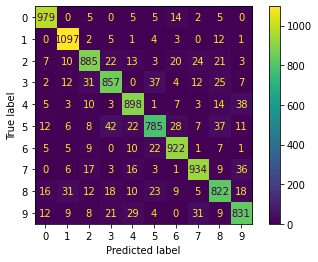

In [25]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(model,X_test/255.0,Y_test)
plt.show()

`OneVsRestClassifier` может превратить любой бинарный классификатор в мультиклассовый. Однако многие классификаторы в SkLearn, включая логистическую регрессию, поддерживают мультиклассовый режим. Поэтому мы можем подавать мультиклассовые данные напрямую на вход `LogisticRegression`:

In [26]:
model = sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1)
model.fit(X_train/255.0, Y_train)
sk.metrics.accuracy_score(Y_test,model.predict(X_test/255.0))

0.9026

Интересно посмотреть на коэффициенты (веса) получившейся модели. В мультиклассовом случае, размерность вектора коэффициентов `model.coef_` будет $10\times784$ - это соответствует 10 классам, по $768=28\times28$ коэффициентов в каждом. Соответственно, можем попробовать визуализировать это как изображение: 

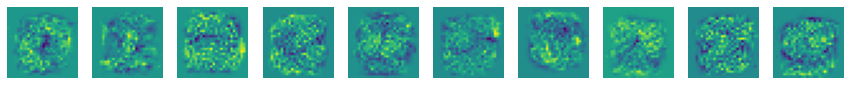

In [29]:
fig,ax = plt.subplots(1,10,figsize=(15,6))
for i in range(10):
    ax[i].imshow(model.coef_[i].reshape(28,28))
    ax[i].axis('off')
plt.show()

Из картинки становится примерно понятно, как работает такой классификатор - он умножает шаблон с коэффициентами на изображение, и выход получается тем больше, чем лучше шаблон совпадает с картинкой. Положительные коэффициенты в шаблоне соответствуют тем пикселям, которые должны присутствовать для данной цифры, а отрицательные - те, которые для такой цифры не характерны.

### Кросс-валидация

Для проверки точности модели мы обычно использовали подход с разбиением выборки на обучающую и тестовую. Однако в этом случае часть выборки "теряется" и не используется для обучения; кроме того - есть вероятность, что конкретное разбиение на обучающую и тестовую выборку оказалось каким-то "неудачным".

Для преодоления этих сложностей может использоваться подход, называемый **кросс-валидацией** (*K-Fold Cross-Validation*). В этом случае датасет разделяется на $k$ частей, и проводится $k$ экспериментов, в которых одна из частей используется для валидации, а остальные - для обучения. Полученные результаты (точность) затем усредняются.

Scikit Learn позволяет провести обучение с кросс-валидацией:

In [30]:
model = sk.linear_model.LogisticRegression(solver='newton-cg',tol=0.1)
scores = sk.model_selection.cross_val_score(model,X/255.0,Y,cv=5) 
scores

array([0.92192857, 0.92128571, 0.91521429, 0.91828571, 0.92978571])

In [31]:
scores.mean(), scores.std()

(0.9212999999999999, 0.004868767601681531)

В методе `cross_val_score` можно задавать различные метрики для оценки, а также различные стратегии разбиения датасета (с помощью параметра `cv`).

Существует также метод `cross_val_predict`, возвращающий предсказания можели для каждого из элементов входного датасета в то время, когда он был частью тестовой выборки.

Если же нам нужно вернуть сами обученные модели, полученные в процессе кросс-валидации, то можно использовать метод `cross_validate`. Подробнее об особенностях использования этого метода можно почитать [в документации](https://scikit-learn.org/stable/modules/cross_validation.html).